## Redis Interface Examples

This notebook demonstrates how the Redis Interface allows the Open Perception pipeline to be easily integrated with other frameworks.

Table of Contents:
- Setup
- Redis Interface Syncronous
- Redis Interface Asyncronous


### Setup
Follow the instruction to setup the environment and install the required packages for the open_perception pipeline.


> :exclamation: Your application doesn't need to have the same python environment as the open perception pipeline! The redis interface allows the communication between different environments.


Start the open perception with the redis interface
```bash
conda activate open_perception
python src/main.py --config config/redis_interface.yaml
# wait for the pipeline to start
```
or uncomment and run the cell below

In [ ]:
# import subprocess
## conda run -n open_perception python ../src/main.py --config ../config/redis_interface.yaml
# subprocess.Popen(['conda', 'run', '-n', 'open_perception', 'python', '../src/main.py', '--config', '../config/redis_interface.yaml'])

<Popen: returncode: None args: ['conda', 'run', '-n', 'open_perception', 'py...>

### Redis Interface Syncronous

In [1]:
from open_perception.communication.redis_client import RedisClient
from open_perception.utils.config_loader import load_config

# load redis config from default config file
config = load_config("../config/redis_interface.yaml") # loads form config/default.yaml
redis_config = config["communication"]["redis"]

client = RedisClient(config=redis_config)
client.connect()
client.reset()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using custom config file


## Single Image detections 

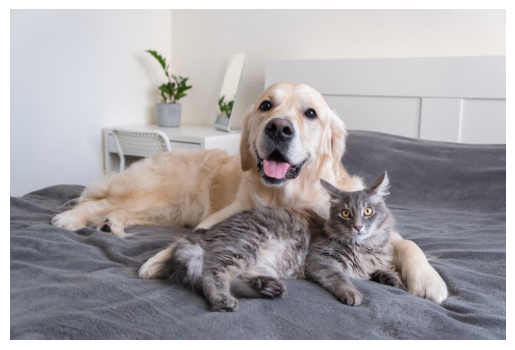

In [1]:
from matplotlib import pyplot as plt
import cv2
image_file = "images/cat_and_dog.png"
# load image as np array
image = cv2.imread(image_file)
plt.imshow(image[:,:,::-1]); plt.axis('off'); plt.show()

In [3]:
client.connect()
# client.reset()

client.send_frame("front",rgb=image, fake_pc=True, wait=True)
elements = client.locate(["dog", "cat"], wait=True)
client.disconnect()

masked_image = client.generate_masked_frame(elements, image.copy())
plt.imshow(masked_image[:,:,::-1]); plt.axis('off'); plt.show()

KeyboardInterrupt: 

### Multigranular detections

Searching for elements in a hierarchical order.

e.g. locating the for the eyes of the dog in the image 

The query: `dog.eyes` aims to first locate a 'dog' and then locate the 'eyes' inside of the cropped image of the dog.

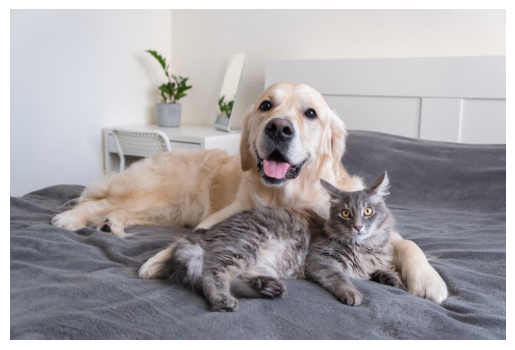

In [6]:
client.connect()
client.reset()

client.send_frame("front",rgb=image, fake_pc=True, wait=True)
elements = client.locate(["dog.eyes"], wait=True)
client.disconnect()

masked_image = client.generate_masked_frame(elements, image.copy())
plt.imshow(masked_image[:,:,::-1]); plt.axis('off'); plt.show()

## Video stream example 

In [6]:
from open_perception.utils.common import load_video_frames
# Load video frames
video_path = "sample.mp4"
frames = load_video_frames(video_path)
print("Loaded {} frames".format(len(frames)))

from IPython.display import Video
Video(video_path)

Loaded 32 frames


In [7]:
from tqdm import tqdm
import numpy as np

fake_pc = np.zeros_like(frames[0]).astype(np.float64)
client.connect()
client.reset()

client.send_frame("front",rgb=frames[0], point_cloud=fake_pc)
client.locate(["cloth", "table"], wait=True)

masked_frames = []
for i, rgb in tqdm(enumerate(frames)):

	client.send_frame("front",rgb=rgb, fake_pc=True, wait=True)
	
	# obj_state = client.get_object_state("cloth")
	elements = client.get_detection_elements()
	masked_frames.append(client.generate_masked_frame(elements, rgb.copy()))

client.disconnect()




32it [00:10,  3.04it/s]


In [12]:
import moviepy.video.io.ImageSequenceClip
import cv2
video_frames = [f[:,:,::-1] for f in masked_frames]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(video_frames, fps=30)
clip.write_videofile("masked_sample.mp4")
Video("masked_sample.mp4")

MoviePy - Building video masked_sample.mp4.
MoviePy - Writing video masked_sample.mp4



MoviePy - Done !
MoviePy - video ready masked_sample.mp4


### RGBD video stream

TODO: Convert to RGB and PointCloud  

## Redis Interface Asyncronous

In [ ]:
client.send_frame("camera_1",rgb=rgb, meta={"id":i})
client.disconnect()